In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

In [4]:
import pickle
import json

In [6]:
def plot_gr(gr, start=0, end=-1, log = False, all_ticks = False,  s=10):
    plt.figure(figsize=(s,s))
    if end == -1:
        end = gr.shape[0]
    if log:
        plt.imshow(np.log(gr[start:end,start:end] + 1))
    else:
        plt.imshow(gr[start:end,start:end])
    plt.colorbar()
    if all_ticks: 
        plt.xticks(np.arange(start,end))
        plt.yticks(np.arange(start,end))
    plt.show()

In [7]:
from nltk import ngrams

In [8]:
np.random.binomial(1, 0.5, 10)

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 1])

In [9]:
SWITCH_PROB = 0.2
AMPLIFY_PROB = 1.
STOP_PROB = 0
MAX_LEN = 5

In [10]:
MAX_LEN = 6
population = np.ones((3,MAX_LEN + 1)) * -1
population[0,0:6] = np.arange(0,6)
population[0,0] = 0
population[1,0:6] = np.arange(6,12)
population[1,0] = 1
population[2,0:6] = np.arange(12,18)
population[2,0] = 2
population

array([[ 0.,  1.,  2.,  3.,  4.,  5., -1.],
       [ 1.,  7.,  8.,  9., 10., 11., -1.],
       [ 2., 13., 14., 15., 16., 17., -1.]])

In [11]:
population_f = population.copy()
population_b = reverse_population(population_f)

NameError: name 'reverse_population' is not defined

In [12]:
single_amplify(population_f, np.ones(3), 1,1)

NameError: name 'single_amplify' is not defined

In [13]:
population_f

array([[ 0.,  1.,  2.,  3.,  4.,  5., -1.],
       [ 1.,  7.,  8.,  9., 10., 11., -1.],
       [ 2., 13., 14., 15., 16., 17., -1.]])

In [14]:
population_b

NameError: name 'population_b' is not defined

In [15]:
population_f, population_b = PCR_cycle(population_f, population_b, np.array([1,1,1]))

NameError: name 'PCR_cycle' is not defined

In [16]:
def reverse_population(p):
    p_b = p.copy()
    for i in range(p.shape[0]):
        length = (p[i] != -1).sum() - 1
        
        p_b[i,1:length + 1] = p[i,1:length + 1][::-1]
    return p_b

In [17]:
def PCR_cycle(population_f, population_b, switch_weights):       
    new_f = single_amplify(population_f, switch_weights, reverse=0)
    #new_b = single_amplify(population_f, switch_weights)
    
    population_f = np.vstack((population_f, new_f))
    #population_b = np.vstack((population_b, new_b))
    
    return population_f, population_b

In [18]:
def generate_initial_population(spacers_num, chain_number=2, max_amount_per_chain = 2, min_len = 4, v = False):
    # markov is our god! 
    graph = np.zeros((spacers_num, spacers_num))
    for i in range(spacers_num):
        for j in range(spacers_num -1, i, -1):
            graph[i,j] = spacers_num - j

    if v:
        plot_gr(graph)
        
    graph /= np.max(np.vstack((graph.sum(1), np.ones(spacers_num))), 0).reshape(-1,1)
    all_chains = []
    while len(all_chains) < chain_number:
        chain = []
        amount = np.random.randint(1, max_amount_per_chain)
        max_len = max([np.random.randint(min_len,spacers_num + 1) for i in range(3)])
        curr = np.random.randint(0, (spacers_num - 1) / 2 )

        for j in range(max_len):
            chain.append(curr)
            if curr != spacers_num - 1:
                #print(np.arange(spacers_num), graph[curr])
                curr = np.random.choice(np.arange(spacers_num), 1, p = graph[curr])[0]
            else:
                break
        
        if len(chain) > min_len:
            all_chains.extend([chain for k in range(amount)])
    
    return all_chains[:chain_number]

In [19]:
def population_from_list_of_lists(list_of_lists, cassettes_types = None, multiplier = 1):
    max_len = max([len(x) for x in list_of_lists])
    population_f = np.ones((len(list_of_lists), max_len + 1)) * (-1)
    population_b = np.ones((len(list_of_lists), max_len + 1)) * (-1)
    for i,l in enumerate(list_of_lists):
        population_f[i, 1:len(l) + 1] = np.array(l)
        population_b[i, 1:len(l) + 1] = np.array(l[::-1])
        
    if cassettes_types is not None:
        population_f[:,0],population_b[:,0] = [np.array(cassettes_types)]*2
        
    else:
        population_f[:,0],population_b[:,0] = [0]*2
    
    if multiplier > 1:
        population_f = np.vstack([population_f] * multiplier)
        population_b = np.vstack([population_b] * multiplier)
    return population_f, population_b, max_len
        

In [20]:
population_as_list = [[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16] for i in range(5)] + \
               [[4, 2, 5, 7, 11] for i in range(5)] + \
               [[24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34]] + \
               [[20, 22, 23, 21, 29]]

pairs_1 = set([x for y in population_as_list[:10] for x in ngrams(y, 2)])
pairs_2 = set([x for y in population_as_list[10:] for x in ngrams(y, 2)])

In [21]:
all_ratios_plots = []

In [22]:
np.random.randint(1,3,10)

array([2, 1, 1, 1, 2, 1, 2, 2, 2, 1])

In [23]:
def single_amplify(all_population, switch_weights, reverse = True, v = False): 
    mask = np.random.binomial(1, AMPLIFY_PROB, all_population.shape[0]).astype(bool)
    population_to_amplify = all_population[mask] 
    new = np.ones((population_to_amplify.shape[0], MAX_LEN + 1)) * (-1)
    
    if v:
        print(mask)
        print(population_to_amplify)
    
    i = 0
    for chain in population_to_amplify:
        source_len = (chain != -1).sum() - 1 
        to_start = False
        start = 0
        while not to_start and start < source_len:
            start += 1
            if np.random.random() < START_PROB:
                to_start = True
        if v: print("start : ", start)
            
        #start = np.random.randint(1, source_len + 1 - 1)
        stop = False
#        end = np.random.randint(start + 1, source_len + 1)
        
        
        pointer_new = 1
        pointer_source = start
        
        new[i,0] = chain[0]
        
        while not stop:            
            new[i,pointer_new] = chain[pointer_source]
            
            pointer_new += 1
            pointer_source += 1
            
            switch = np.random.rand() < SWITCH_PROB
            
            if v:
                print(chain, new[i], switch)
            if switch:
                mask = np.zeros(1)
                while mask.sum() ==0:
                    chain_type = np.random.choice(np.arange(switch_weights.shape[0]), p = switch_weights / switch_weights.sum())
                    mask = population_to_amplify[:, 0] == chain_type

                chain = population_to_amplify[mask][np.random.randint(0, mask.sum())]
                source_len = (chain != -1).sum() - 1 
                pointer_source = np.random.randint(1, source_len)

            if np.random.rand() < STOP_PROB:
                stop = True
            if pointer_new == new.shape[1]:
                stop = True
#             if pointer_new == end:
#                 stop = True
            if pointer_source == source_len + 1:
                if np.random.rand() < SWITCH_PROB :
                    mask = np.zeros(1)
                    while mask.sum() ==0:
                        chain_type = np.random.choice(np.arange(switch_weights.shape[0]), p = switch_weights / switch_weights.sum())
                        mask = population_to_amplify[:, 0] == chain_type

                    chain = population_to_amplify[mask][np.random.randint(0, mask.sum())]
                    source_len = (chain != -1).sum() - 1 
                    pointer_source = np.random.randint(1, source_len)
                else:
                    stop = True
            
#                 if v:
#                     print(chain, new[i], switch)

#                 mask = np.zeros(1)
#                 while mask.sum() ==0:
#                     chain_type = np.random.choice(np.arange(switch_weights.shape[0]), p = switch_weights / switch_weights.sum())
#                     mask = population_to_amplify[:, 0] == chain_type

#                 chain = population_to_amplify[mask][np.random.randint(0, mask.sum())]
#                 source_len = (chain != -1).sum() - 1 
#                 pointer_source = np.random.randint(1, source_len)
 
                
                
                
                
        if reverse:
            if v:print(new[i], pointer_new)
            new[i, 1:pointer_new] = new[i, pointer_new - 1:0:-1]
            if v:print(new[i])
        if (new[i] != -1).sum() > 2:
            i += 1
        
    
    return new[(new != -1).sum(1) > 2 ]
    
     

In [24]:
SWITCH_PROB = 0.03
AMPLIFY_PROB = 0.3
STOP_PROB = 0.05
START_PROB = 0.85

In [25]:
population_f, population_b, MAX_LEN = population_from_list_of_lists(population_as_list, [0]*10 + [1]*2, 10)

A Jupyter Widget

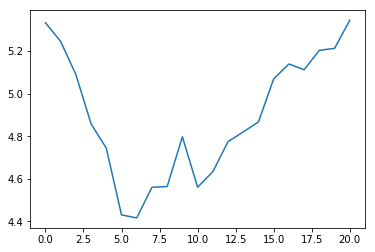

In [26]:
population_ratio = []

for i in tqdm_notebook(range(50)) :
    all_pairs = []
    for seq in np.vstack((population_f,reverse_population(population_b))):
        seq = seq[seq != -1][1:]
        for x in ngrams(seq,2):
            all_pairs.append(x)
            
    cp_1, cp_2, cp_3 = 0,0,0
    for p in all_pairs:
        if p in pairs_1:
            cp_1+=1
        elif p in pairs_2:
            cp_2+=1
        else:
            cp_3+=1

    population_ratio.append(cp_1 / cp_2)
    
    population_f, population_b = PCR_cycle(population_f, population_b, np.array([50,1]))

    if population_f.shape[0] > 20000:
        break

all_ratios_plots.append(population_ratio)

for p_r in all_ratios_plots:
    plt.plot(p_r)
plt.show()

In [21]:
population_f.shape

(20500, 14)

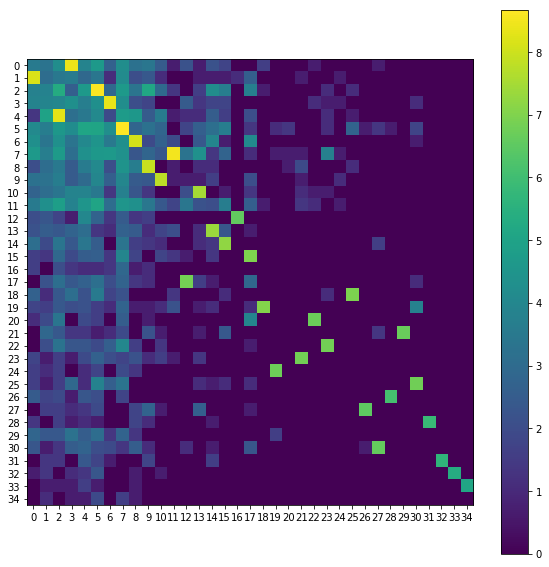

In [24]:
gr = pairs_to_gr(all_pairs, int(population_f.max() + 1))
plot_gr(gr, log= 1,all_ticks=1)

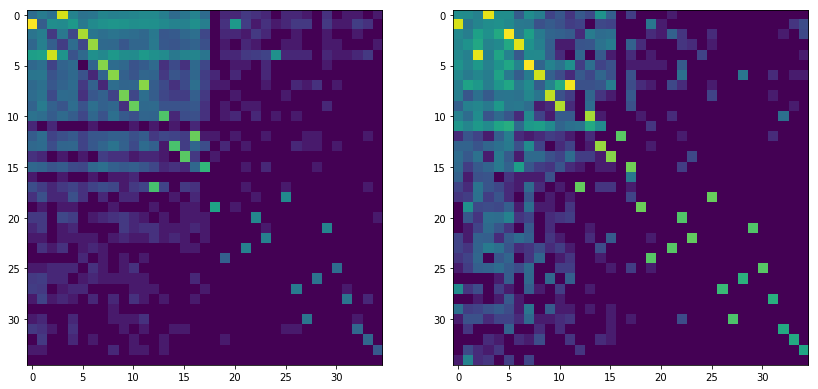

In [1022]:

f, (a1, a2) = plt.subplots(1,2)
f.set_size_inches((14,7))
a1.imshow(np.log(gr_tr + 1))
a2.imshow(np.log(gr + 1))
plt.show()

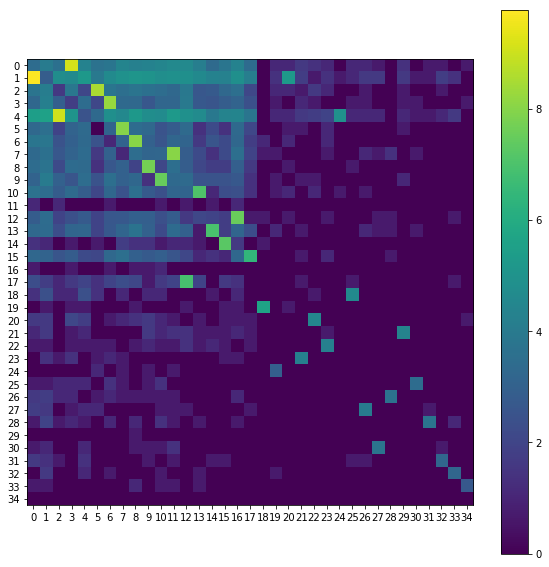

In [969]:
plot_gr(gr_tr, log= 1, all_ticks=1)

In [970]:
gr[5:9, 12:16].sum()

173.0

In [971]:
gr[5:9, 0: 4].sum()

767.0

In [ ]:
np.histogram()

In [983]:
np.logspace(0,np.log10(20000),20)

array([1.e+00, 2.e+04])

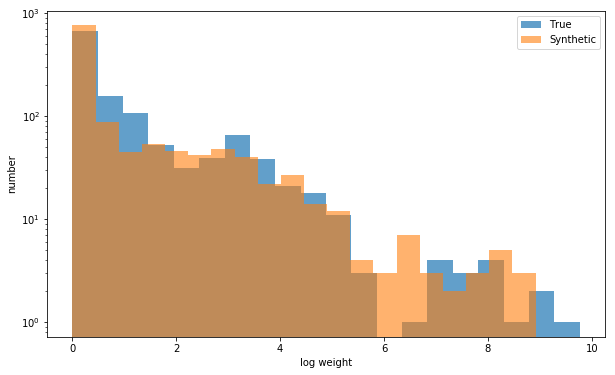

In [997]:
plt.figure(figsize = (10,6))
#bins = np.logspace(0,np.log10(20000),20)
#bins = np.linspace(0,20000,20)
#plt.xticks(np.arange(bins.shape[0]),bins)
plt.xlabel("log weight")
plt.ylabel("number")
bins = 20
plt.hist(np.log(gr_tr.flatten() + 1), bins=bins, log=1, alpha=0.7, label='True')
plt.hist(np.log(gr.flatten() + 1), bins=bins, log=1, alpha = 0.6, label='Synthetic')

plt.legend()
plt.show()

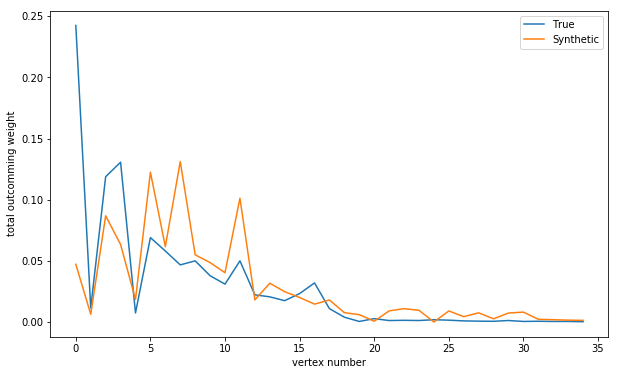

In [1006]:
plt.figure(figsize = (10,6))
plt.xlabel("vertex number")
plt.ylabel("total outcomming weight")

plt.plot(gr_tr.sum(0) / gr_tr.sum(), label='True')
plt.plot(gr.sum(0) / gr.sum(), label='Synthetic')
#plt.hist(np.log(gr.flatten() + 1).sum(0), bins=bins, log=1, alpha = 0.6, label='Synthetic')

plt.legend()
plt.show()

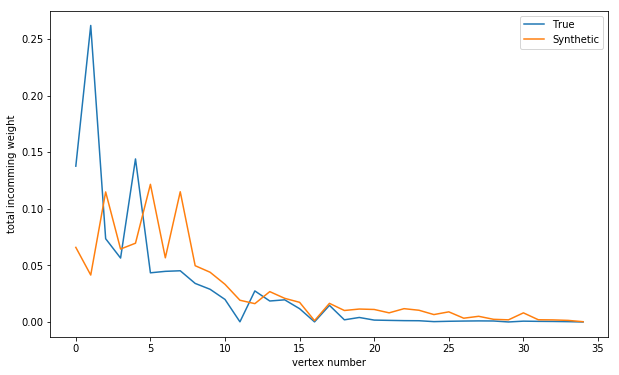

In [1008]:
plt.figure(figsize = (10,6))
plt.xlabel("vertex number")
plt.ylabel("total incomming weight")

plt.plot(gr_tr.sum(1) / gr_tr.sum(), label='True')
plt.plot(gr.sum(1) / gr.sum(), label='Synthetic')
#plt.hist(np.log(gr.flatten() + 1).sum(0), bins=bins, log=1, alpha = 0.6, label='Synthetic')

plt.legend()
plt.show()

In [1003]:
gr_tr.sum(1).astype(int)

array([10276, 19554,  5491,  4215, 10752,  3242,  3339,  3377,  2543,
        2156,  1485,    10,  2047,  1383,  1461,   875,     7,  1097,
         142,   297,   124,   105,    88,    82,    23,    46,    61,
          71,    65,     1,    54,    41,    34,    21,     0])

In [1004]:
gr.sum(1).astype(int)

array([4575, 2878, 7975, 4473, 4831, 8442, 3935, 7986, 3451, 3050, 2309,
       1333, 1124, 1861, 1450, 1205,   82, 1142,  704,  793,  767,  560,
        816,  719,  454,  621,  231,  348,  163,  131,  559,  136,  127,
         97,   16])

In [ ]:
plt.figure(figsize = (8,5))
plt.hist(gr.flatten(), bins=100, log=1, alpha = 0.5)
plt.hist(gr_tr.flatten(), bins=100, log=1, alpha=0.5)
plt.show()

In [ ]:
plt.hist(.flatten(), bins=20)
plt.show()

In [23]:
def pairs_to_gr(pairs, spacers_num):
    graph = np.zeros((spacers_num, spacers_num))
    
    for p in pairs:
        graph[int(p[0]), int(p[1])] += 1
    
    return graph

In [368]:
def amp_population(population_f, population_b, spacers_num, max_chains = 25000, max_epochs = 15):
    epoch = 0
    
    while (population_f.shape[0] + population_b.shape[0] < max_chains) and epoch < max_epochs:
        population_f, population_b = PCR_cycle(population_f, population_b)
        epoch += 1
    
    full_population_amplified = population_f + [x[::-1] for x in population_b]
    
    all_pairs = []
    for seq in full_population_amplified:
        for x in ngrams(seq,2):
            all_pairs.append(x)

    graph = np.zeros((spacers_num, spacers_num))
    for p in all_pairs:
        graph[p[0],p[1]] += 1
        
    return graph

In [414]:
def reshuffle(population, spacers_num):
    spacers_shuffled = np.arange(spacers_num)
    np.random.shuffle(spacers_shuffled)
    shuffle_map = dict(zip(np.arange(spacers_num), spacers_shuffled))
    
    return [[shuffle_map[x] for x in y] for y in population]

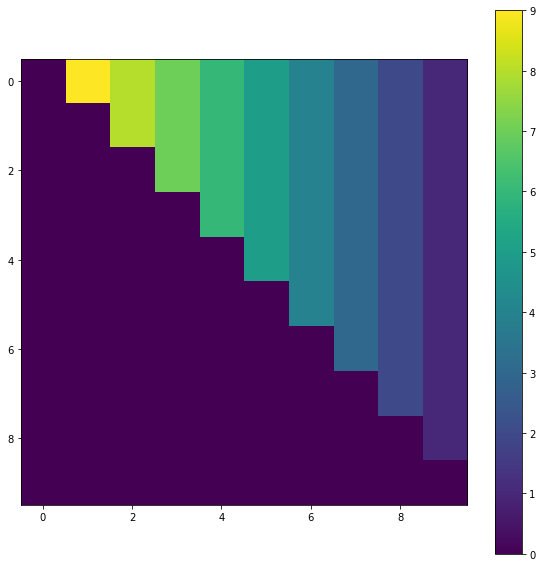

[[2, 5, 7, 8, 9],
 [2, 5, 7, 8, 9],
 [2, 5, 7, 8, 9],
 [3, 4, 7, 8, 9],
 [3, 4, 7, 8, 9],
 [1, 2, 6, 8, 9]]

In [421]:
pp = generate_initial_population(10, 6, 10, v =1)
pp

In [429]:
gr = amp_population(pp, 10, 100000, 30)

In [431]:
def population_to_gr(population, spacers_num):
    graph = np.zeros((spacers_num, spacers_num))
    
    for chain in population:
        for p in ngrams(chain, 2):
            graph[p[0], p[1]] = 1
    
    return graph

In [436]:
def complete_population(population, shape):
    answ = np.ones(shape) * -1
    
    for i, chain in enumerate(population):
        answ[i, :len(chain)] = np.array(chain)
    return answ

In [461]:
params = {"N_POPULATONS" : 5000,
            "N_SPACERS" : 10,
            "N_CHAINS" : 6,
            "MAX_LEN" : 10,
            "SWITCH_PROB" : 0.05,
            "AMPLIFY_PROB"  :0.35,
            "STOP_PROB" : 0,
            "MAX_POPULATION_SIZE" : 10000}

SWITCH_PROB = params["SWITCH_PROB"]
AMPLIFY_PROB = params["AMPLIFY_PROB"]
STOP_PROB = params["STOP_PROB"]

synthetic_populations = np.zeros((params["N_POPULATONS"], params["N_CHAINS"], params["MAX_LEN"]))
amp_graphs = np.zeros((params["N_POPULATONS"], params["N_SPACERS"], params["N_SPACERS"]))
initial_graphs = np.zeros((params["N_POPULATONS"], params["N_SPACERS"], params["N_SPACERS"]))


for i in tqdm_notebook(range(params["N_POPULATONS"])):
    p = generate_initial_population(params["N_SPACERS"], params["N_CHAINS"], 10)
    synthetic_populations[i] = complete_population(p, (params["N_CHAINS"], params["N_SPACERS"] ))

    amp_graphs[i] = amp_population(p, params["N_SPACERS"], params["MAX_POPULATION_SIZE"], 20)
    initial_graphs[i] = population_to_gr(p, params["N_SPACERS"])

A Jupyter Widget

In [467]:
np.save("../data/simulation/init5k/populations", synthetic_populations)
np.save("../data/simulation/init5k/populations_gr", initial_graphs)
np.save("../data/simulation/init5k/amp_gr", amp_graphs)
json.dump(params, open("../data/simulation/init5k/params.json", 'w'))

In [ ]:
json.dump()

A Jupyter Widget

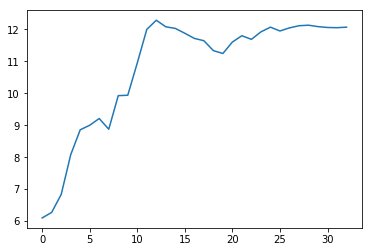

In [265]:
population_ratio = []

for i in tqdm_notebook(range(35)) :
    PCR_cycle(population_f, population_b)
    
    all_pairs = []
    for seq in population_f + [x[::-1] for x in population_b]:
        for x in ngrams(seq,2):
            all_pairs.append(x)
            
    cp_1, cp_2, cp_3 = 0,0,0
    for p in all_pairs:
        if p in pairs_1:
            cp_1+=1
        elif p in pairs_2:
            cp_2+=1
        else:
            cp_3+=1
            
#     c_1, c_2, c_3 = 0,0,0
#     for p in population_f:
#         for l in p:
#             if l in [0,1,2,3,4,5]:
#                 c_1+=1
#             elif l in [6,7,8,9]:
#                 c_2+=1
#             else:
#                 c_3+=1
    #print(len(population_f), c_1, c_2, c_3, c_1 / c_2)
    population_ratio.append(cp_1 / cp_2)
    
    #print(len(population_f))#, len(population_b))
    if len(population_f) >100000:
        break

all_ratios_plots.append(population_ratio)


for p_r in all_ratios_plots:
    plt.plot(p_r)
plt.show()



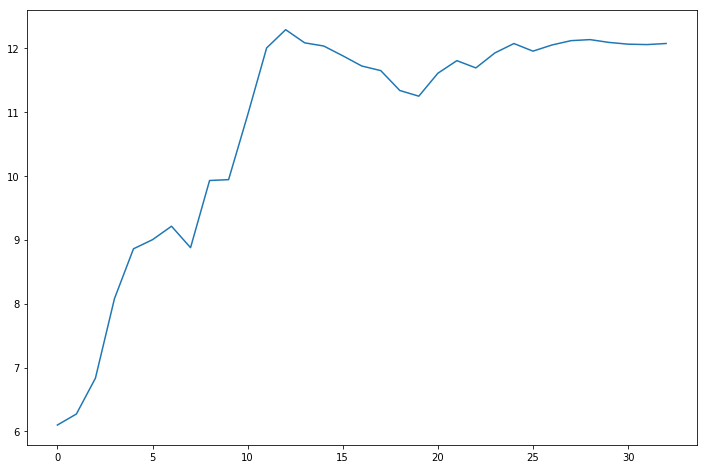

In [266]:
plt.figure(figsize=(12,8))

for p_r in all_ratios_plots:
    plt.plot(p_r)
plt.show()


In [167]:
c_1 / c_2

15.804110043089162

In [267]:
population = population_f + [x[::-1] for x in population_b]

In [134]:
all_pairs = []
for seq in population:
    for x in ngrams(seq,2):
        all_pairs.append(x)
len(all_pairs)

33222

In [268]:
graph = np.zeros((11,11))

for p in all_pairs:
    graph[p[0],p[1]] += 1

In [269]:
c_1, c_2, c_3 = 0,0,0
for p in all_pairs:
    if p in pairs_1:
        c_1+=1
    elif p in pairs_2:
        c_2+=1
    else:
        c_3+=1

In [270]:
print(c_1, c_2, c_3, c_1 / c_2)

224870 18631 22514 12.069668831517363


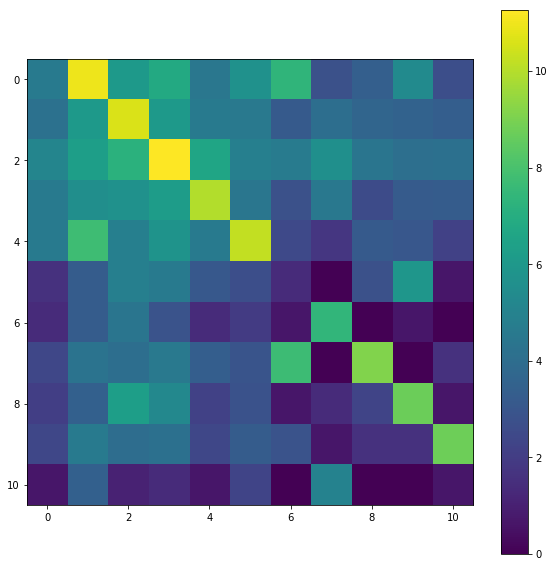

In [271]:
plot_gr(graph, log = 1)

In [589]:
c_2

3162

In [336]:
c_3

18988

In [480]:
pairs_1

<generator object ngrams at 0x7f7b6a570e60>

In [479]:
all_pairs[:30]

[(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 0),
 (0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 0),
 (0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 0),
 (0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 0),
 (0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (0, 6)]

In [283]:
ES3_b

[[16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1],
 [16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1],
 [16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1],
 [16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1],
 [16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1],
 [11, 7, 5, 2, 4],
 [11, 7, 5, 2, 4],
 [11, 7, 5, 2, 4],
 [11, 7, 5, 2, 4],
 [11, 7, 5, 2, 4],
 [34, 33, 32, 31, 28, 26, 27, 30, 25, 18, 19, 24],
 [29, 21, 23, 22, 20],
 [17, 15, 14],
 [13, 10, 9],
 [6, 3, 0],
 [11, 7],
 [7, 5, 2],
 [11, 7, 5, 2],
 [11, 7, 5, 2, 4],
 [32, 31],
 [29, 21],
 [16, 12, 17, 15, 14],
 [16, 12, 17, 15],
 [8, 6],
 [10, 9],
 [11, 7, 5, 2],
 [11, 7],
 [11, 7],
 [7, 5, 2],
 [12, 17, 15, 14],
 [14, 17, 15],
 [2, 4],
 [28, 26, 27, 30],
 [22, 20],
 [12, 17, 15],
 [16, 12],
 [12, 17],
 [6, 3],
 [11, 7, 5, 2],
 [11, 7, 5],
 [11, 7, 5, 2],
 [34, 33, 32, 31, 28, 26, 27, 30],
 [29, 21],
 [12, 17],
 [17, 15],
 [28, 26, 27, 30],
 [0, 1],
 [0, 1],
 [5, 2, 4],
 [5, 2, 4],
 [23, 22],
 [3, 0],
 [11, 7],
 [16, 12, 17, 15, 14, 13, 10, 9, 8

In [284]:
ES3_f

[[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [4, 2, 5, 7, 11],
 [4, 2, 5, 7, 11],
 [4, 2, 5, 7, 11],
 [4, 2, 5, 7, 11],
 [4, 2, 5, 7, 11],
 [24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [20, 22, 23, 21, 29],
 [13, 14, 15, 17, 12],
 [13, 14, 15, 17, 14],
 [1, 0, 3],
 [4, 2],
 [4, 2, 5],
 [5, 7, 11],
 [25, 30, 27, 26, 28],
 [20, 22],
 [1, 0],
 [1, 0, 3, 6, 8, 9, 10, 13],
 [1, 0],
 [1, 0],
 [4, 2, 5, 7],
 [4, 2, 5, 7],
 [4, 2, 5],
 [18, 25],
 [22, 23],
 [0, 3],
 [7, 11],
 [5, 7],
 [2, 5],
 [1, 15],
 [6, 8, 9, 10, 13],
 [3, 6],
 [1, 0, 3, 6, 8, 9],
 [1, 0, 3, 6],
 [4, 2, 5],
 [4, 2, 5, 7],
 [4, 2],
 [19, 18, 25, 30, 27],
 [22, 23],
 [14, 15, 17],
 [0, 3],
 [2, 5],
 [4, 2],
 [9, 10],
 [7, 11],
 [2, 5, 7],
 [4, 2],
 [30, 27],
 [20, 22],
 [1, 0],
 [3, 6],
 [4, 2, 5],
 [4, 2],
 [19, 18],
 [1

In [53]:
population=reshuffle(population, np.arange(10))

In [272]:
m = np.ones((3,3))

In [365]:
pp = generate_initial_population(5, 6, 5)
ppr = reshuffle(pp,5)
print(pp)
print(ppr)

[[0.         0.25       0.25       0.25       0.25      ]
 [0.         0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         0.5        0.5       ]
 [0.         0.         0.         0.         1.        ]
 [0.         0.         0.         0.         0.        ]]
5
5
4
[[0, 3, 4], [0, 3, 4], [1, 3, 4], [1, 3, 4], [0, 1, 3, 4], [0, 1, 3, 4]]
[[3, 1, 4], [3, 1, 4], [2, 1, 4], [2, 1, 4], [3, 2, 1, 4], [3, 2, 1, 4]]


In [684]:
population_f = [[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16] for i in range(5)] + \
        [[4, 2, 5, 7, 11] for i in range(5)] + \
        [[24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34]] + \
        [[20, 22, 23, 21, 29]]
        
population_b = [x[::-1] for x in population_f]